<Axes: xlabel='year'>

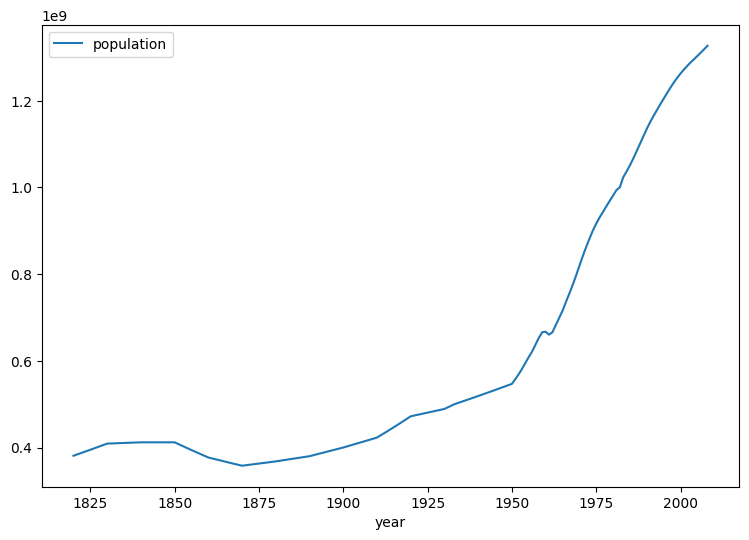

In [4]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

series1 = pd.read_csv(
    "./total-population.csv",
    index_col=0
)
series1.plot(figsize=(9, 6))
# 呈现出明显的增长趋势，就一定不是平稳时间序列

(5.0, -5.0)

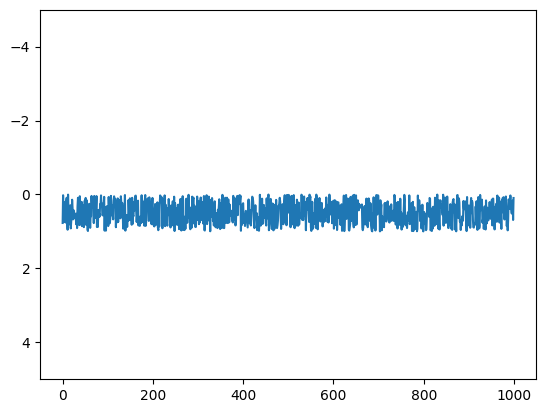

In [5]:
import numpy as np

np.random.seed(10)  # 随机数种子
series2 = np.random.rand(1000)  # 生成随机序列
plt.plot(series2)  # 绘图
plt.ylim(5, -5)  # 限定 y 轴范围
# 序列围绕着某个值上下随机波动，没有明显的趋势和周期性。一般来讲，我们会认为这类序列是平稳的

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

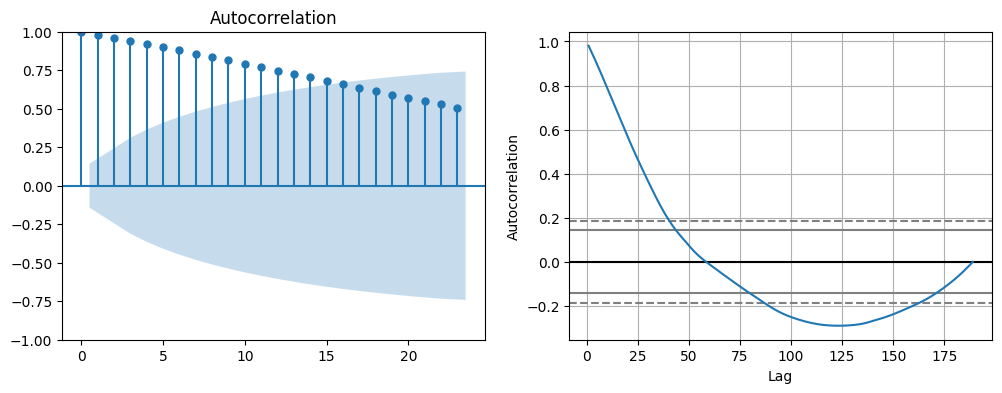

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

plot_acf(series1, ax=axes[0])
autocorrelation_plot(series1, ax=axes[1])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

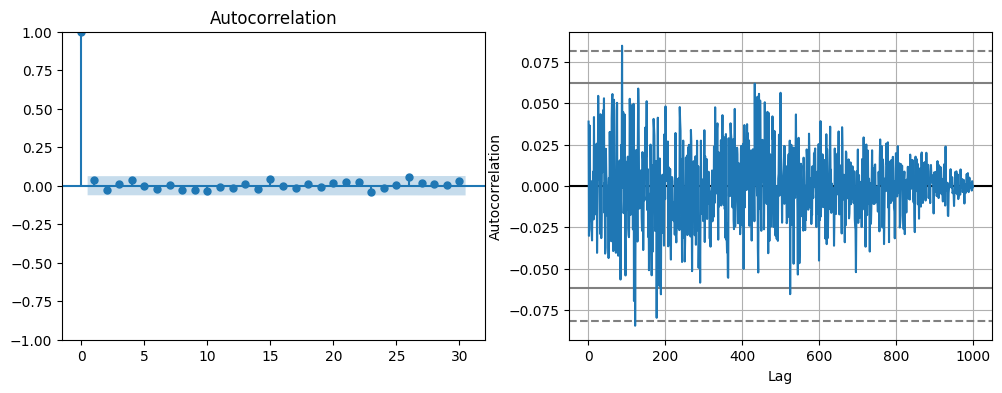

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

plot_acf(series2, ax=axes[0])
autocorrelation_plot(series2, ax=axes[1])

In [ ]:
#  series2 对应的自相关图中显示的序列自相关系数一直较小，在 0 附近震荡波动，那么我们会认为这是一个随机性非常强的平稳时间序列。

In [ ]:
# 纯随机性检验

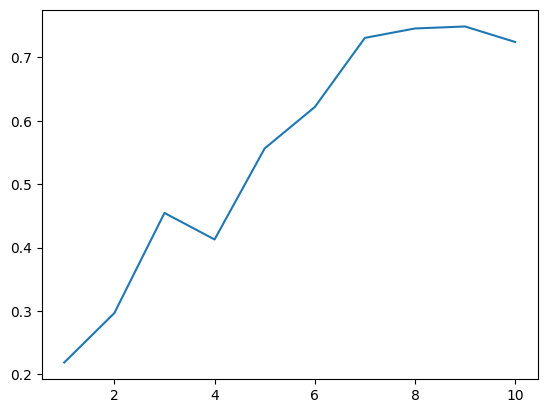

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

P2 = acorr_ljungbox(series2).lb_pvalue
plt.plot(P2)
# LB 统计量的 P 值远大于 0.05。所以，可以判定其为随机序列，也就再无分析必要了

<Axes: >

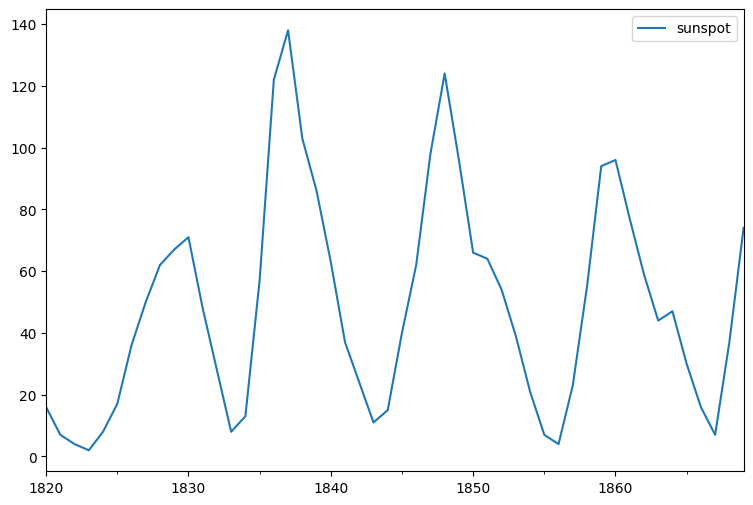

In [10]:
series3 = pd.read_csv(
    "./sunspot.csv",
    index_col=0
)
series3.index = pd.period_range("1820", "1869", freq="Y")  # 将索引转换为时间
series3.plot(figsize=(9, 6))

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

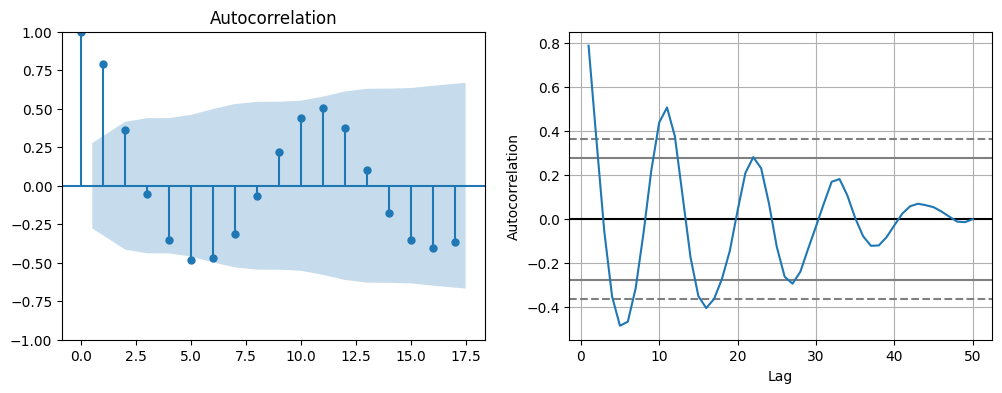

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

plot_acf(series3, ax=axes[0])
autocorrelation_plot(series3, ax=axes[1])

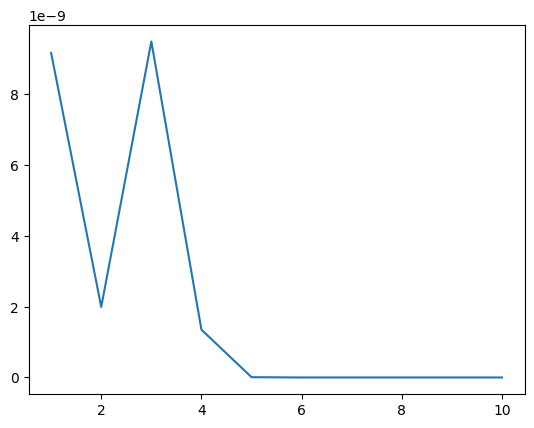

In [12]:
# 自相关图随着延迟期数增加，接近于 0。但没有像上面随机序列那样在 0 附近波动，而后面由呈现出周期变化。所以，可以判断其为周期变化平稳序列

P3 = acorr_ljungbox(series3).lb_pvalue
plt.plot(P3)
# P 值远小于 0.05（注意纵轴单位），那么说明序列为非纯随机序列

In [13]:
import warnings
from statsmodels.tsa.stattools import arma_order_select_ic

train_data = series3[:-10]  # 80% 训练
test_data = series3[-10:]

warnings.filterwarnings("ignore")
arma_order_select_ic(train_data, ic="aic")["aic_min_order"]  # AIC

(2, 1)

In [14]:
arma_order_select_ic(train_data, ic="bic")["bic_min_order"]  # BIC

(2, 0)

In [15]:
arma_order_select_ic(train_data, ic="hqic")["hqic_min_order"]  # HQIC

(2, 1)

In [16]:
# 计算方法不一样带来的结果不一样，可以都尝试一下看看结果。既然 AIC 和 HQIC 结果一致。那我们就按照 AIC 方法
from statsmodels.tsa.arima.model import ARIMA

arma = ARIMA(train_data, order=(2, 0, 1)).fit()  # 定义并训练模型

In [17]:
arma.forecast(steps=10).values

array([111.37037437, 100.57459279,  75.88578452,  51.33635556,
        35.73963196,  31.42983175,  35.80573126,  44.0878926 ,
        51.84682463,  56.47354742])

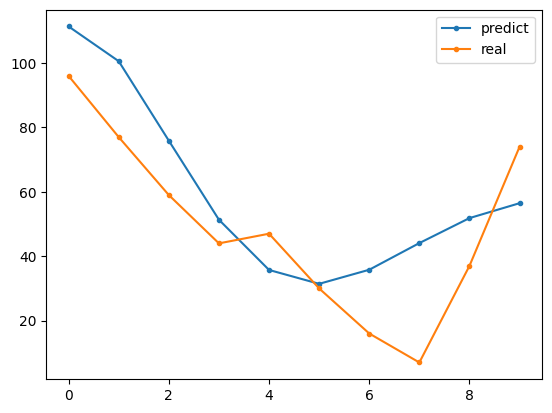

In [18]:
plt.plot(arma.forecast(steps=10).values, ".-", label="predict")  # 输出后续 10 个预测结果
plt.plot(test_data.values, ".-", label="real")
plt.legend()

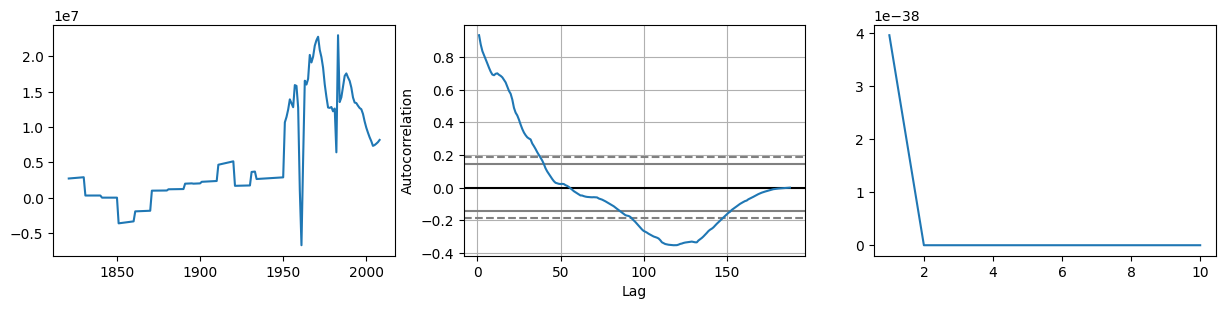

In [19]:
# 序列进行 1 阶差分运算
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))

diff1 = series1.diff().dropna()  # 1 阶差分

axes[0].plot(diff1)  # 绘图
autocorrelation_plot(diff1, ax=axes[1])  # 平稳性检验
axes[2].plot(acorr_ljungbox(diff1).lb_pvalue)  # 纯随机检验

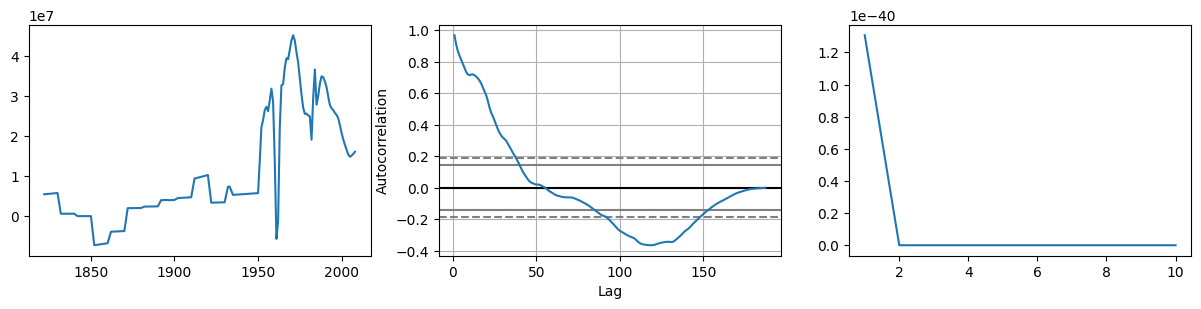

In [20]:
 #  1 阶 2 步差分

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))

diff1 = series1.diff(periods=2).dropna()  # 1 阶 2 步差分

axes[0].plot(diff1)  # 绘图
autocorrelation_plot(diff1, ax=axes[1])  # 平稳性检验
axes[2].plot(acorr_ljungbox(diff1).lb_pvalue)  # 纯随机检验

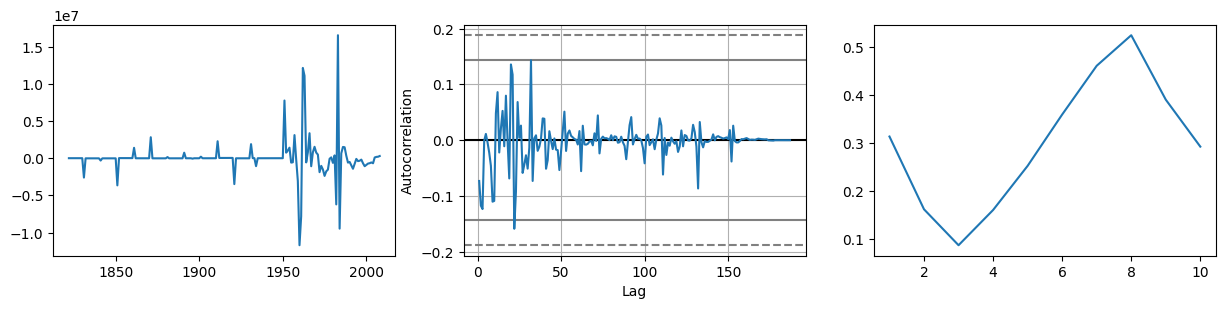

In [21]:
# 2 阶差分
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))

diff2 = series1.diff().diff().dropna()  # 2 阶差分

axes[0].plot(diff2)  # 绘图
autocorrelation_plot(diff2, ax=axes[1])  # 平稳性检验
axes[2].plot(acorr_ljungbox(diff2).lb_pvalue)  # 纯随机检验

In [ ]:
# 虽然二阶差分后，lb_pvalue 明显 > 0.05,但是它让数据明显平稳了，可以尝试继续分析下去

In [22]:
# 对差分后的数据进行 p、q 计算
train_data = series1[:-40]  # 约 80% 训练
test_data = series1[-40:]

arma_order_select_ic(train_data.diff().dropna(), ic="aic")["aic_min_order"]  # AIC

(3, 0)

In [24]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train_data, order=(3, 2, 0)).fit()  # 定义并训练模型

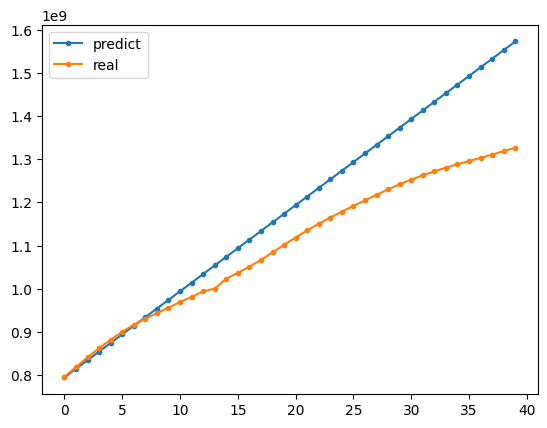

In [25]:
plt.plot(arima.forecast(steps=40).values, ".-", label="predict")  # 输出后续 40 个预测结果
plt.plot(test_data.values, ".-", label="real")
plt.legend()